In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
def loaddata(file_path):
  tree = ET.parse(file_path)
  root = tree.getroot()
  namespace = {'cwa': root.tag.split('}')[0][1:]}
  geo_info_node = root.find('./cwa:dataset/cwa:GeoInfo', namespace)
  start_lon_str = geo_info_node.find('cwa:BottomLeftLongitude', namespace).text
  start_lat_str = geo_info_node.find('cwa:BottomLeftLatitude', namespace).text
  start_lon = float(start_lon_str)
  start_lat = float(start_lat_str)
  content_node = root.find('./cwa:dataset/cwa:Resource/cwa:Content', namespace)
  raw_data_string = content_node.text

  raw_data_string = raw_data_string.strip()
  lines = raw_data_string.splitlines()

  grid_data = []
  for line in lines:
      line_content = line.strip()
      if not line_content: continue
      values_str = line_content.replace('  ', ' ').split(',')
      values = [float(v) for v in values_str if v.strip()]
      if values:
          grid_data.append(values)
  return grid_data, start_lon, start_lat


In [31]:
temperature_grid = loaddata("/content/O-A0038-003.xml")

In [32]:
def classification_dataset(grid_data, start_lon, start_lat):
    resolution = 0.03
    num_rows = len(grid_data)
    num_cols = len(grid_data[0]) if num_rows > 0 else 0
    print(f"{num_rows} x {num_cols}")
    classification_data = []
    for row_idx in range(num_rows):
        for col_idx in range(num_cols):
            current_lat = start_lat + row_idx * resolution
            current_lon = start_lon + col_idx * resolution
            temp_value = grid_data[row_idx][col_idx]
            label = 0 if temp_value == -999.0 else 1
            classification_data.append((round(current_lon, 2), round(current_lat, 2), label))

    return classification_data

In [33]:
class ClassificationModel(nn.Module):
    def __init__(self):
        super(ClassificationModel, self).__init__()
        # 輸入層：2個特徵 (經度, 緯度)
        # 隱藏層1：16個神經元
        # 隱藏層2：8個神經元
        # 輸出層：1個神經元
        self.network = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

In [43]:
def train_and_evaluate(model, train_loader, val_loader, epochs=30, learning_rate=0.001):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_auc': []
    }

    print("\n--- 開始訓練與評估 ---")
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * features.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)

        model.eval()
        val_running_loss = 0.0
        all_val_labels = []
        all_val_preds = []

        with torch.no_grad():
            for features, labels in val_loader:
                outputs = model(features).squeeze()
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * features.size(0)

                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(outputs.cpu().numpy())

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_auc = roc_auc_score(all_val_labels, all_val_preds)

        history['val_loss'].append(epoch_val_loss)
        history['val_auc'].append(epoch_val_auc)

        print(f"Epoch [{epoch+1:02d}/{epochs}] - "
              f"Train Loss: {epoch_train_loss:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} | "
              f"Val AUC: {epoch_val_auc:.4f}")

    print("--- 訓練完成 ---")
    return history


In [44]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # 繪製 Loss 曲線
    ax1.plot(history['train_loss'], 'o-', label='Training Loss')
    ax1.plot(history['val_loss'], 'o-', label='Validation Loss')
    ax1.set_title('Loss vs. Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # 繪製 AUC 曲線
    ax2.plot(history['val_auc'], 'o-', label='Validation AUC', color='green')
    ax2.set_title('Validation AUC vs. Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean AUC')
    ax2.legend()
    ax2.grid(True)

    plt.show()

In [45]:
def evaluate_on_test_set(model, test_loader):
    model.eval()
    all_test_labels = []
    all_test_preds = []

    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features).squeeze()
            all_test_labels.extend(labels.cpu().numpy())
            all_test_preds.extend(outputs.cpu().numpy())

    test_auc = roc_auc_score(all_test_labels, all_test_preds)
    print("\n--- 最終模型在測試集上的表現 ---")
    print(f"Test Set AUC: {test_auc:.4f}")
    return test_auc

120 x 67

資料集切分完成:
訓練集大小: 5628
驗證集大小: 1206
測試集大小: 1206

--- 開始訓練與評估 ---
Epoch [01/30] - Train Loss: 0.6776 | Val Loss: 0.6597 | Val AUC: 0.8667
Epoch [02/30] - Train Loss: 0.6287 | Val Loss: 0.6098 | Val AUC: 0.8994
Epoch [03/30] - Train Loss: 0.5767 | Val Loss: 0.5590 | Val AUC: 0.9162
Epoch [04/30] - Train Loss: 0.5268 | Val Loss: 0.5092 | Val AUC: 0.9330
Epoch [05/30] - Train Loss: 0.4814 | Val Loss: 0.4652 | Val AUC: 0.9544
Epoch [06/30] - Train Loss: 0.4395 | Val Loss: 0.4249 | Val AUC: 0.9685
Epoch [07/30] - Train Loss: 0.4027 | Val Loss: 0.3919 | Val AUC: 0.9770
Epoch [08/30] - Train Loss: 0.3717 | Val Loss: 0.3632 | Val AUC: 0.9817
Epoch [09/30] - Train Loss: 0.3453 | Val Loss: 0.3403 | Val AUC: 0.9849
Epoch [10/30] - Train Loss: 0.3230 | Val Loss: 0.3207 | Val AUC: 0.9864
Epoch [11/30] - Train Loss: 0.3039 | Val Loss: 0.3040 | Val AUC: 0.9872
Epoch [12/30] - Train Loss: 0.2862 | Val Loss: 0.2820 | Val AUC: 0.9885
Epoch [13/30] - Train Loss: 0.2365 | Val Loss: 0.2123 | Val AUC:

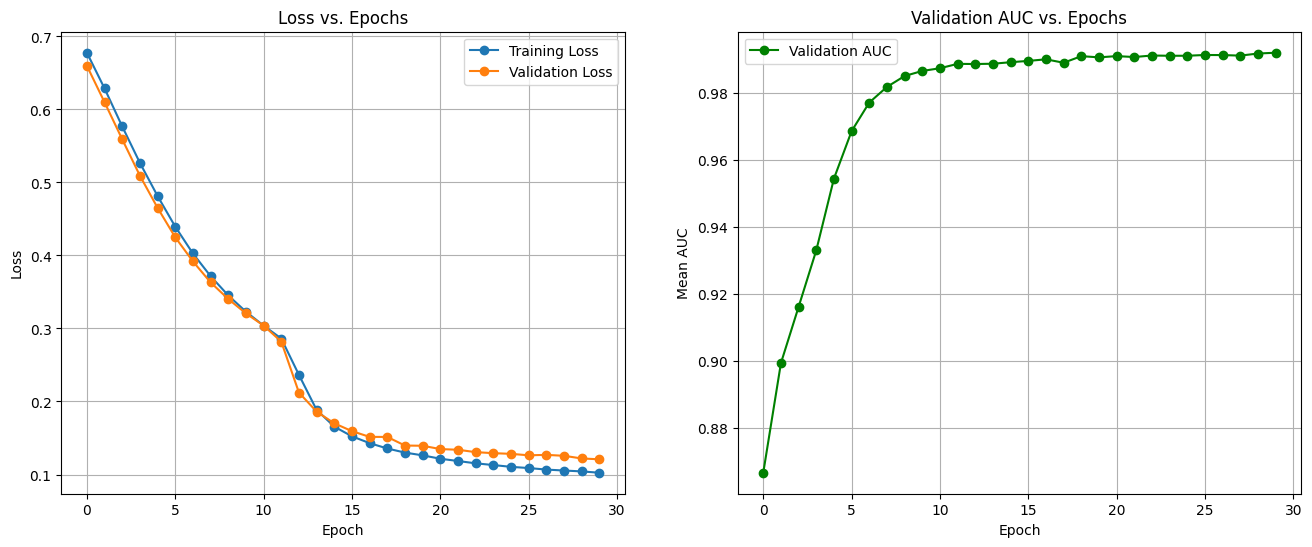


--- 最終模型在測試集上的表現 ---
Test Set AUC: 0.9941


In [46]:
if __name__ == "__main__":
    file_path = '/content/O-A0038-003.xml'
    load_result = loaddata(file_path)

    if load_result:
        temperature_grid, start_lon, start_lat = load_result
        classification_data = classification_dataset(temperature_grid, start_lon, start_lat)

        features = torch.tensor([[lon, lat] for lon, lat, _ in classification_data], dtype=torch.float32)
        labels = torch.tensor([label for _, _, label in classification_data], dtype=torch.float32)

        mu = features.mean(dim=0)
        sigma = features.std(dim=0)
        features = (features - mu) / sigma

        dataset = TensorDataset(features, labels)
        dataset_size = len(dataset)
        train_size = int(0.7 * dataset_size)
        val_size = int(0.15 * dataset_size)
        test_size = dataset_size - train_size - val_size

        train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

        print(f"\n資料集切分完成:")
        print(f"訓練集大小: {len(train_dataset)}")
        print(f"驗證集大小: {len(val_dataset)}")
        print(f"測試集大小: {len(test_dataset)}")

        # 建立 DataLoader
        batch_size = 64
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        # 實例化模型
        cls_model = ClassificationModel()

        # 訓練並獲取歷史紀錄
        history = train_and_evaluate(cls_model, train_loader, val_loader, epochs=30)

        # 繪製結果
        plot_history(history)

        # 在測試集上評估最終模型
        evaluate_on_test_set(cls_model, test_loader)

In [48]:
from sklearn.metrics import roc_auc_score, mean_absolute_error, mean_squared_error

In [47]:
def regression_dataset(grid_data, start_lon, start_lat):
    resolution = 0.03
    regression_data = []
    for row_idx, row_values in enumerate(grid_data):
        for col_idx, celsius_temp in enumerate(row_values):
            if celsius_temp != -999.0:
                current_lat = start_lat + row_idx * resolution
                current_lon = start_lon + col_idx * resolution

                fahrenheit_temp = (celsius_temp * 9/5) + 32

                regression_data.append((round(current_lon, 2), round(current_lat, 2), fahrenheit_temp))

    return regression_data

In [49]:
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.network(x)

In [50]:
def train_and_evaluate_regression(model, train_loader, val_loader, epochs=50, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_mae': []
    }

    print("\n--- 開始訓練迴歸模型 ---")
    for epoch in range(epochs):
        # 訓練
        model.train()
        running_loss = 0.0
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * features.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_train_loss)

        # 驗證
        model.eval()
        val_running_loss = 0.0
        all_val_labels = []
        all_val_preds = []

        with torch.no_grad():
            for features, labels in val_loader:
                outputs = model(features).squeeze()
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * features.size(0)

                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(outputs.cpu().numpy())

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_mae = mean_absolute_error(all_val_labels, all_val_preds)

        history['val_loss'].append(epoch_val_loss)
        history['val_mae'].append(epoch_val_mae)

        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1:02d}/{epochs}] - "
                  f"Train Loss (MSE): {epoch_train_loss:.4f} | "
                  f"Val Loss (MSE): {epoch_val_loss:.4f} | "
                  f"Val MAE: {epoch_val_mae:.4f}")

    print("--- 訓練完成 ---")
    return history

In [54]:
def plot_regression_history(history, label_std):
    val_mae_original_scale = np.array(history['val_mae']) * label_std

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.plot(history['train_loss'], 'o-', label='Training Loss (MSE)')
    ax1.plot(history['val_loss'], 'o-', label='Validation Loss (MSE)')
    ax1.set_title('Loss (MSE) vs. Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Standardized MSE')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(val_mae_original_scale, 'o-', label='Validation MAE', color='purple')
    ax2.set_title('Validation MAE vs. Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Mean Absolute Error (°F)')
    ax2.legend()
    ax2.grid(True)

    plt.show()

In [55]:
def evaluate_regression_on_test_set(model, test_loader, label_mean, label_std):
    model.eval()
    all_labels_orig = []
    all_preds_orig = []

    with torch.no_grad():
        for features, labels in test_loader:
            outputs = model(features).squeeze()
            labels_orig = labels.cpu().numpy() * label_std + label_mean
            preds_orig = outputs.cpu().numpy() * label_std + label_mean

            all_labels_orig.extend(labels_orig)
            all_preds_orig.extend(preds_orig)

    test_mae = mean_absolute_error(all_labels_orig, all_preds_orig)
    test_rmse = np.sqrt(mean_squared_error(all_labels_orig, all_preds_orig))

    print("\n--- 最終迴歸模型在測試集上的表現 (單位：華氏度 °F) ---")
    print(f"Test Set MAE: {test_mae:.4f} °F")
    print(f"Test Set RMSE: {test_rmse:.4f} °F")
    print("\n--- 迴歸模型預測範例 ---")
    idx = np.random.randint(0, len(all_labels_orig))
    print(f"範例 #{idx}:")
    print(f"模型預測溫度: {all_preds_orig[idx]:.2f} °F")
    print(f"實際溫度: {all_labels_orig[idx]:.2f} °F")
    print(f"誤差: {abs(all_preds_orig[idx] - all_labels_orig[idx]):.2f} °F")


         執行 (b) 迴歸 (Regression) 任務

成功建立迴歸資料集，僅保留 3495 筆有效資料。
前5筆資料範例 (lon, lat, temp°F): [(120.84, 21.94, 82.58), (120.72, 21.97, 83.48), (120.75, 21.97, 83.48), (120.78, 21.97, 82.04), (120.81, 21.97, 79.7)]

特徵與目標已標準化。
溫度均值(mu): 70.86°F, 標準差(sigma): 11.06°F

--- 開始訓練迴歸模型 ---
Epoch [01/50] - Train Loss (MSE): 0.9195 | Val Loss (MSE): 0.7997 | Val MAE: 0.6754
Epoch [05/50] - Train Loss (MSE): 0.3506 | Val Loss (MSE): 0.3881 | Val MAE: 0.4587
Epoch [10/50] - Train Loss (MSE): 0.3002 | Val Loss (MSE): 0.3440 | Val MAE: 0.4143
Epoch [15/50] - Train Loss (MSE): 0.2865 | Val Loss (MSE): 0.3187 | Val MAE: 0.4061
Epoch [20/50] - Train Loss (MSE): 0.2721 | Val Loss (MSE): 0.3085 | Val MAE: 0.4013
Epoch [25/50] - Train Loss (MSE): 0.2657 | Val Loss (MSE): 0.2986 | Val MAE: 0.3951
Epoch [30/50] - Train Loss (MSE): 0.2587 | Val Loss (MSE): 0.2875 | Val MAE: 0.3793
Epoch [35/50] - Train Loss (MSE): 0.2539 | Val Loss (MSE): 0.2858 | Val MAE: 0.3740
Epoch [40/50] - Train Loss (MSE): 0.2484 | Val L

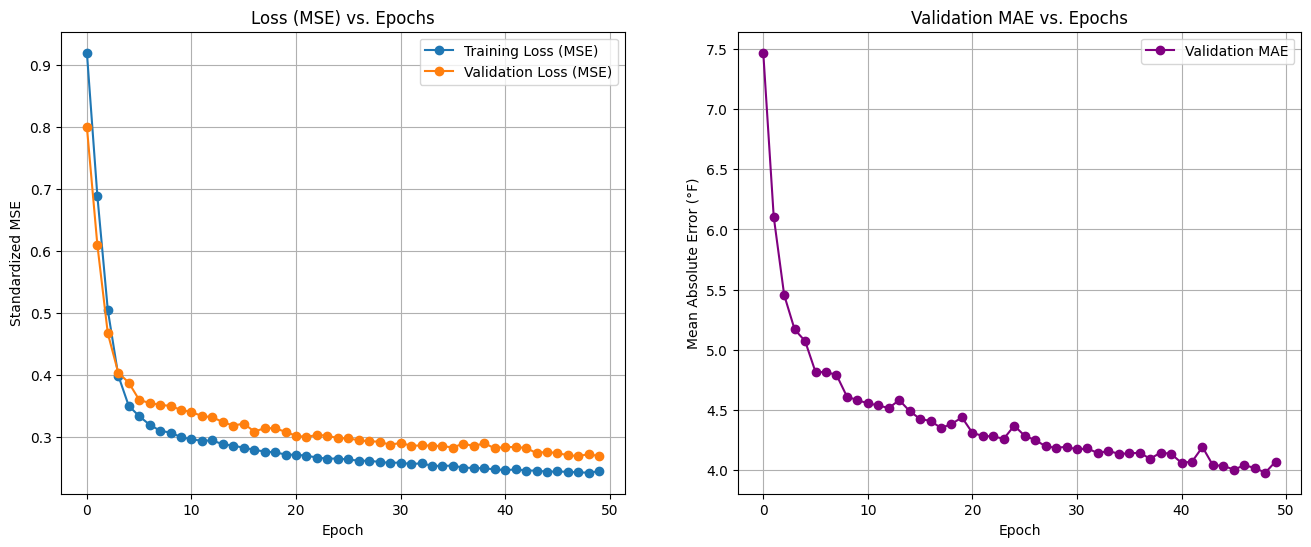


--- 最終迴歸模型在測試集上的表現 (單位：華氏度 °F) ---
Test Set MAE: 4.1809 °F
Test Set RMSE: 5.8894 °F

--- 迴歸模型預測範例 ---
範例 #34:
模型預測溫度: 54.31 °F
實際溫度: 66.20 °F
誤差: 11.89 °F


In [57]:
if __name__ == "__main__":
    file_path = '/content/O-A0038-003.xml'
    load_result = loaddata(file_path)

    if load_result:
        temperature_grid, start_lon, start_lat = load_result

        # --- 執行迴歸任務 ---
        print("\n" + "="*50)
        print("         執行 (b) 迴歸 (Regression) 任務")
        print("="*50)

        regression_data = regression_dataset(temperature_grid, start_lon, start_lat)
        print(f"\n成功建立迴歸資料集，僅保留 {len(regression_data)} 筆有效資料。")
        print(f"前5筆資料範例 (lon, lat, temp°F): {regression_data[:5]}")

        features = torch.tensor([[lon, lat] for lon, lat, _ in regression_data], dtype=torch.float32)
        labels = torch.tensor([[val] for _, _, val in regression_data], dtype=torch.float32) # 維持二維

        feature_mu, feature_sigma = features.mean(dim=0), features.std(dim=0)
        label_mu, label_sigma = labels.mean(), labels.std()

        features = (features - feature_mu) / feature_sigma
        labels = (labels - label_mu) / label_sigma

        print(f"\n特徵與目標已標準化。")
        print(f"溫度均值(mu): {label_mu.item():.2f}°F, 標準差(sigma): {label_sigma.item():.2f}°F")

        dataset = TensorDataset(features, labels.squeeze()) # DataLoader需要一維的label


        train_size = int(0.7 * len(dataset))
        val_size = int(0.15 * len(dataset))
        test_size = len(dataset) - train_size - val_size
        train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32)
        test_loader = DataLoader(test_dataset, batch_size=32)

        reg_model = RegressionModel()
        history = train_and_evaluate_regression(reg_model, train_loader, val_loader, epochs=50)

        plot_regression_history(history, label_sigma.item())
        evaluate_regression_on_test_set(reg_model, test_loader, label_mu.item(), label_sigma.item())